Pos Tech - MLET - Tech Challenge - Fase 4

Usar a versão Python 3.10.6 no Kernel

[*********************100%%**********************]  1 of 1 completed
c:\Users\lucia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0066 - val_loss: 8.3233e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.8094e-04 - val_loss: 0.0041
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6022e-04 - val_loss: 0.0012
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.3014e-04 - val_loss: 0.0011
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.1428e-04 - val_loss: 6.8022e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.0357e-04 - val_loss: 0.0013
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.6192e-04 - val_loss: 7.0917e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7260e-04 - val_loss: 0.0020
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.4523e-04 - val_loss: 6.4206e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4554e-04 - val_loss: 0.0010
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Absolute Error (MAE): 11.30
Root Mean Square Error (

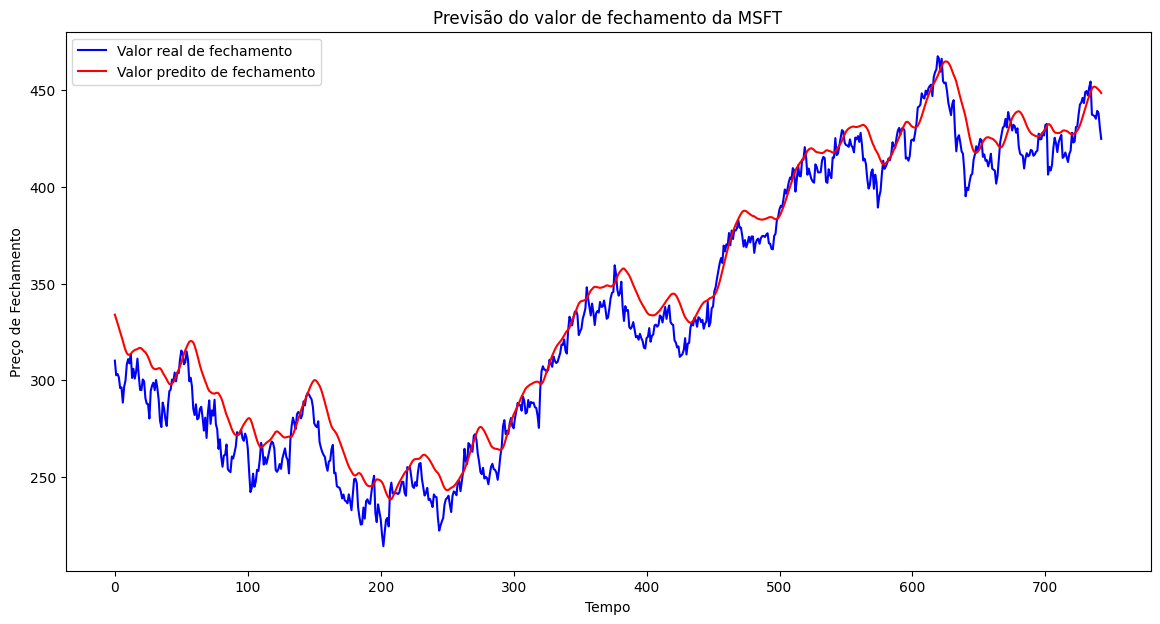

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Baixar os dados históricos da Microsoft (MSFT)
data = yf.download('MSFT', start='2010-01-01', end='2025-01-01')

# Apenas o preço de fechamento
data = data[['Close']]

# Normalizar os dados (escala entre 0 e 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Criar conjunto de dados para treinamento
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Entradas (últimos 60 dias)
        y.append(data[i + time_step, 0])  # Saída (preço de fechamento)
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape para LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Criar o modelo LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Regularização

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Saída única (preço de fechamento)

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Fazer previsões
predictions = model.predict(X_test)

# Reverter a normalização dos dados
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Funções para calcular as métricas de erro
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cálculo das métricas de erro
mae = mean_absolute_error(y_test_rescaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
mape = mean_absolute_percentage_error(y_test_rescaled, predictions)

# Exibir as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plotar os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, color='blue', label='Valor real de fechamento')
plt.plot(predictions, color='red', label='Valor predito de fechamento')
plt.title('Previsão do valor de fechamento da MSFT')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

### Explicação do código:

1. **Obtenção dos dados**: Utilizamos a API `yfinance` para baixar os dados históricos de ações da Microsoft (MSFT) de 2010 a 2025. O foco é no preço de fechamento.

2. **Pré-processamento dos dados**:
   - A escala dos dados é ajustada para o intervalo de 0 a 1 usando `MinMaxScaler`, que ajuda a LSTM a aprender de maneira mais eficiente.
   - A função `create_dataset` cria sequências de dados (time series), onde usamos os últimos 60 dias para prever o próximo dia.

3. **Construção do modelo LSTM**:
   - O modelo é construído com duas camadas LSTM, seguidas de camadas Dropout para prevenir overfitting.
   - A última camada é uma camada `Dense` com uma única unidade de saída para prever o valor de fechamento.

4. **Treinamento e Previsões**:
   - O modelo é treinado por 10 épocas (esse número pode ser ajustado conforme necessário).
   - As previsões são feitas no conjunto de teste e são revertidas para a escala original.

5. **Avaliação do modelo**:
   - O modelo é avaliado usando métricas estatísticas após fazer previsões nos dados de teste.
   - Utilizamos três métricas principais:
     - **MAE (Erro Absoluto Médio)**: Mede o erro médio absoluto das previsões. Quanto menor, melhor. Indica a média da diferença absoluta entre o valor real e o predito.
     - **RMSE (Erro Quadrático Médio)**: Dá maior peso a erros maiores, útil para entender a variação dos erros. Deve ser próximo do MAE, mas penaliza grandes desvios.
     - **MAPE (Erro Percentual Absoluto Médio)**: Mede o erro percentual das previsões em relação ao valor real. Indica o erro médio percentual em relação ao valor real (exemplo: um MAPE de 5% significa que as previsões erram, em média, 5% do valor real).

6. **Visualização**: O gráfico mostra as previsões (linha vermelha) comparadas com os valores reais de fechamento (linha azul).

### Resultados:
- O modelo fornecerá uma previsão do valor de fechamento das ações da Microsoft para os próximos dias com base nas últimas 60 observações.
- A precisão do modelo pode ser melhorada ajustando hiperparâmetros como número de épocas, unidades LSTM, etc.